In [9]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.14.0


In [10]:
raw_dataset = pd.read_csv("AQI.csv")

dataset = raw_dataset.copy()
dataset.tail()

,SO2,NO2,O3,PM2.5,PM10,AT,WD,WS,RH,AQI
1211,10.59,71.42,58.083535,183.35,490.73,21.26,281.16,1.11,46.31,486.699565
1212,8.04,18.32,16.492738,211.56,497.73,20.97,266.64,0.58,47.66,496.743043
1213,24.11,12.23,11.733019,225.89,697.16,21.70,134.50,0.81,49.94,782.881739
1214,20.35,10.84,79.467810,268.73,631.05,22.09,90.84,1.51,50.27,688.028261
1215,19.45,10.24,102.297460,236.23,579.75,22.48,205.79,0.46,54.56,614.423913


In [11]:
dataset.isna().sum()

SO2      0
NO2      0
O3       0
PM2.5    0
PM10     0
AT       0
WD       0
WS       0
RH       0
AQI      0
dtype: int64

In [12]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [13]:
train_stats = train_dataset.describe()
train_stats.pop("AQI")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
SO2,973.0,21.098412,22.530118,0.960,11.72,18.70,25.050000,607.90
NO2,973.0,90.674049,50.454199,0.240,54.81,83.85,117.100000,408.93
O3,973.0,33.733917,24.764774,3.330,16.26,25.47,41.633981,120.84
PM2.5,973.0,155.500336,113.989571,20.260,68.85,119.95,212.930000,848.55
PM10,973.0,413.082360,232.295493,17.194,232.17,384.20,559.560000,1790.75
AT,973.0,27.458926,6.760468,10.300,22.09,29.52,32.430000,41.54
WD,973.0,188.517778,62.326196,63.740,131.93,195.41,245.710000,301.26
WS,973.0,1.369221,0.993623,0.300,0.68,1.11,1.800000,13.85
RH,973.0,50.530808,15.297263,6.520,40.71,51.02,60.960000,90.57


In [14]:
train_labels = train_dataset.pop('AQI')
test_labels = test_dataset.pop('AQI')

In [15]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [16]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [17]:
model = build_model()

W0708 18:21:37.723933 140352001050432 deprecation.py:506] From /home/shivamkapila/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [19]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.25282097],
       [-0.14064158],
       [-0.35119927],
       [-0.2578844 ],
       [-0.3892152 ],
       [-0.0767258 ],
       [-0.20224997],
       [-0.3449547 ],
       [-0.32446316],
       [-0.53360057]], dtype=float32)

In [20]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [21]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,12.755303,2.522051,12.755304,53.853300,5.612715,53.853302,995
996,10.428885,2.316803,10.428885,54.077978,5.463131,54.077976,996
997,11.243253,2.522952,11.243253,48.794817,4.926564,48.794823,997
998,11.179961,2.424411,11.179962,63.720941,5.673755,63.720940,998
999,11.201714,2.442862,11.201715,56.592482,5.641842,56.592484,999


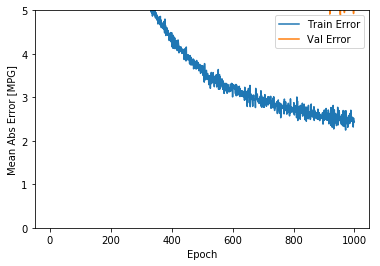

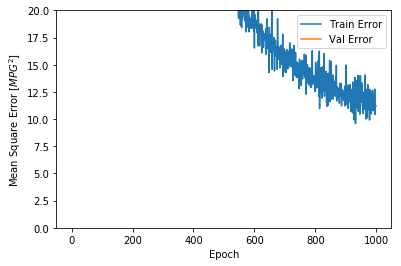

In [22]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


....................................................................................................
..............................................................................................

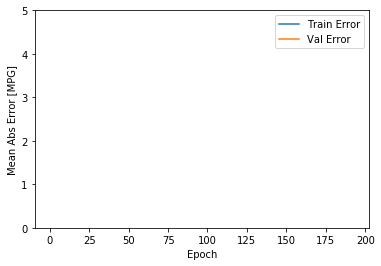

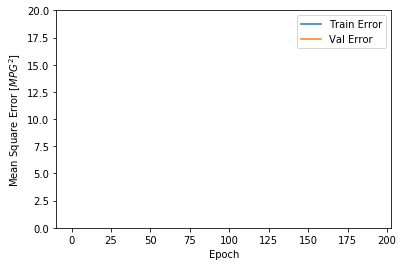

In [23]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [25]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  9.25 MPG


In [26]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


NameError: name 'test_predictions' is not defined